<a href="https://colab.research.google.com/github/SujayVivek/TradingStrategies/blob/main/PotfolioManager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Develop a comprehensive Python script to download historical price data for multiple assets using yfinance, clean and process the data, and perform an in depth analysis of a diversified portfolio's performance. This task requires advanced DataFrame manipulations, including **handling missing data, adjusting for corporate actions, calculating portfolio metrics, and visualizing results**.

In [ ]:
!pip install yfinance

###Importing necessary libraries


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

###Loading the different Tickers, and downloading the data using yfinance

In [19]:
tickers = ['AAPL','MSFT','GOOGL','AMZN','TSLA','NVDA','JPM','VTI','GLD', 'BTC-USD']
start_date = '2015-01-01'
end_date = '2025-01-01'
data = yf.download(tickers, start=start_date, end=end_date, group_by=tickers, auto_adjust= False)

data.to_csv('stock_data.csv')

[*********************100%***********************]  10 of 10 completed
ERROR:yfinance:
10 Failed downloads:
ERROR:yfinance:['MSFT', 'JPM', 'AAPL', 'TSLA', 'AMZN', 'BTC-USD', 'VTI', 'GOOGL', 'NVDA', 'GLD']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


###Code to store the downloaded Data into Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

data.to_csv('/content/drive/MyDrive/stock_data.csv')


Mounted at /content/drive


In [6]:
data = pd.read_csv('/content/drive/MyDrive/stock_data.csv', header=[0,1], index_col=0, parse_dates=True)


In [7]:
print(data.columns.levels)


[['AAPL', 'AMZN', 'BTC-USD', 'GLD', 'GOOGL', 'JPM', 'MSFT', 'NVDA', 'TSLA', 'VTI'], ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']]


###Creating a dataframe containing Adj Close, and Close for each Ticker

In [8]:
adj_close = pd.DataFrame({ticker: data[ticker]['Adj Close'] for ticker in tickers})
close = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})
prices = pd.concat({'Adjusted Close': adj_close, 'Close': close}, axis = 1)

###See how many missing entries present in the data collected!

In [9]:
missing_data = data.isnull().sum()
print(missing_data)
print(data.shape)

Ticker   Price    
JPM      Open         0
         High         0
         Low          0
         Close        0
         Adj Close    0
         Volume       0
MSFT     Open         0
         High         0
         Low          0
         Close        0
         Adj Close    0
         Volume       0
AAPL     Open         0
         High         0
         Low          0
         Close        0
         Adj Close    0
         Volume       0
TSLA     Open         0
         High         0
         Low          0
         Close        0
         Adj Close    0
         Volume       0
BTC-USD  Open         0
         High         0
         Low          0
         Close        0
         Adj Close    0
         Volume       0
AMZN     Open         0
         High         0
         Low          0
         Close        0
         Adj Close    0
         Volume       0
VTI      Open         0
         High         0
         Low          0
         Close        0
         Adj Close   

###Interpolate Missing Data & Dropping Data which have more than 5 continuous missing entries

In [10]:
prices_interp = prices.interpolate(method='time')

In [11]:
is_na = prices.isna()

In [12]:
long_gaps = is_na.rolling(window = 6).sum()>=6
to_drop = long_gaps.any(axis=1).shift(-5).fillna(False)

In [13]:
prices_clean = prices_interp[~to_drop]

In [14]:
prices_clean.isna().sum()

,,0


###Since, there are still some missing data after Interpolation - it is mainly due to the data being at the starting or at the ending. So we can cover that up using ffill, and bfill

In [15]:
prices_clean = prices_clean.ffill().bfill()

In [16]:
print("Remaining NaNs after final fill:")
print(prices_clean.isna().sum().sum())


Remaining NaNs after final fill:
0.0


In [17]:
from scipy.optimize import minimize

In [18]:
prices_clean.columns

MultiIndex([], )

####Taking only the Adjusted Close values from all Tickers

In [ ]:
adj_close = prices_clean.xs('Adjusted Close', axis=1, level=0)
asset_returns = adj_close.pct_change().dropna()

In [ ]:
tickers = adj_close.columns.tolist()
print(tickers)

['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'JPM', 'VTI', 'GLD', 'BTC-USD']


###Getting User Defined Weights:

In [ ]:
def get_user_weights(tickers):
    """
    Prompt user to input comma-separated weights that sum to 1.
    Returns a pd.Series indexed by tickers.
    """
    prompt = (
        f"Enter {len(tickers)} weights (comma-separated) for:\n"
        f"{', '.join(tickers)}\n→ "
    )
    raw = input(prompt)
    w   = np.array([float(x) for x in raw.split(',')])
    if not np.isclose(w.sum(), 1):
        raise ValueError("Weights must sum to 1")
    return pd.Series(w, index=tickers)

In [ ]:
user_weights      = get_user_weights(tickers)
portfolio_returns = asset_returns.dot(user_weights)
cumulative_returns = (1 + portfolio_returns).cumprod()

print("\nUser‐Defined Weights:")
print(user_weights)
print("\nSample Portfolio Returns:")
print(portfolio_returns.head())
print("\nEnd Cumulative Return:")
print(cumulative_returns.iloc[-1])

Enter 10 weights (comma-separated) for:
AAPL, MSFT, GOOGL, AMZN, TSLA, NVDA, JPM, VTI, GLD, BTC-USD
→ 0.05, 0.05, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1

User‐Defined Weights:
AAPL       0.05
MSFT       0.05
GOOGL      0.15
AMZN       0.15
TSLA       0.10
NVDA       0.10
JPM        0.10
VTI        0.10
GLD        0.10
BTC-USD    0.10
dtype: float64

Sample Portfolio Returns:
Date
2015-01-02    0.000249
2015-01-03   -0.016447
2015-01-04   -0.011736
2015-01-05   -0.001897
2015-01-06   -0.008486
Freq: D, dtype: float64

End Cumulative Return:
24.560770223634453


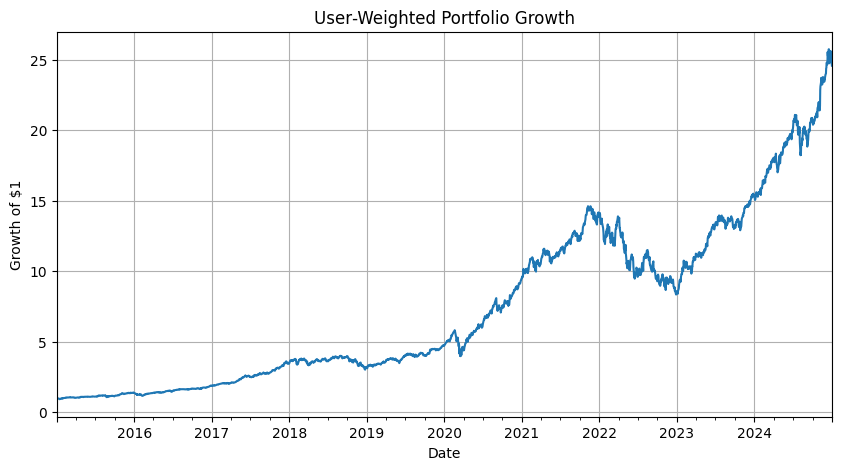

In [ ]:
plt.figure(figsize=(10,5))
cumulative_returns.plot(title="User‐Weighted Portfolio Growth")
plt.xlabel("Date"); plt.ylabel("Growth of $1"); plt.grid(True)
plt.show()

##Lets try and find out the weights! to optimize sharpe ratio

In [ ]:
def portfolio_performance(weights, returns, risk_free=0.0, trading_days=252):
    """Return annualized (return, vol, sharpe)."""
    mean_ret = returns.mean() * trading_days
    cov_mat  = returns.cov()  * trading_days
    port_ret = weights.dot(mean_ret)
    port_vol = np.sqrt(weights.dot(cov_mat).dot(weights))
    sharpe   = (port_ret - risk_free) / port_vol
    return port_ret, port_vol, sharpe

In [ ]:
def optimize_sharpe(returns, risk_free=0.0):
    """Maximize Sharpe ratio."""
    n     = returns.shape[1]
    init  = np.ones(n) / n
    bounds= ((0,1),) * n
    cons  = {'type':'eq', 'fun': lambda w: w.sum() - 1}
    result = minimize(
        lambda w: -portfolio_performance(w, returns, risk_free)[2],
        init, method='SLSQP',
        bounds=bounds, constraints=cons
    )
    if not result.success:
        raise RuntimeError(result.message)
    return pd.Series(result.x, index=returns.columns)

In [ ]:
def optimize_min_vol(returns):
    """Minimize annualized volatility."""
    n     = returns.shape[1]
    init  = np.ones(n) / n
    bounds= ((0,1),) * n
    cons  = {'type':'eq', 'fun': lambda w: w.sum() - 1}
    result = minimize(
        lambda w: portfolio_performance(w, returns)[1],
        init, method='SLSQP',
        bounds=bounds, constraints=cons
    )
    if not result.success:
        raise RuntimeError(result.message)
    return pd.Series(result.x, index=returns.columns)

In [ ]:
sharpe_weights = optimize_sharpe(asset_returns, risk_free=0.03)
minvol_weights = optimize_min_vol(asset_returns)




Optimized Weights (Max Sharpe):
AAPL       1.436863e-02
MSFT       7.205540e-17
GOOGL      5.539257e-17
AMZN       6.250301e-02
TSLA       3.953259e-02
NVDA       2.362654e-01
JPM        9.482360e-02
VTI        0.000000e+00
GLD        4.271367e-01
BTC-USD    1.253700e-01
dtype: float64

Annualized Return: 24.42%
Annualized Volatility: 15.65%
Sharpe Ratio: 1.56


##To calculate new cumulative returns after Optimizing weights

In [ ]:
portfolio_returns = asset_returns.dot(opt_weights)
cumulative_returns = (1 + portfolio_returns).cumprod()
print("\nEnd Cumulative Return:")
print(cumulative_returns.iloc[-1])


End Cumulative Return:
28.774522683111478


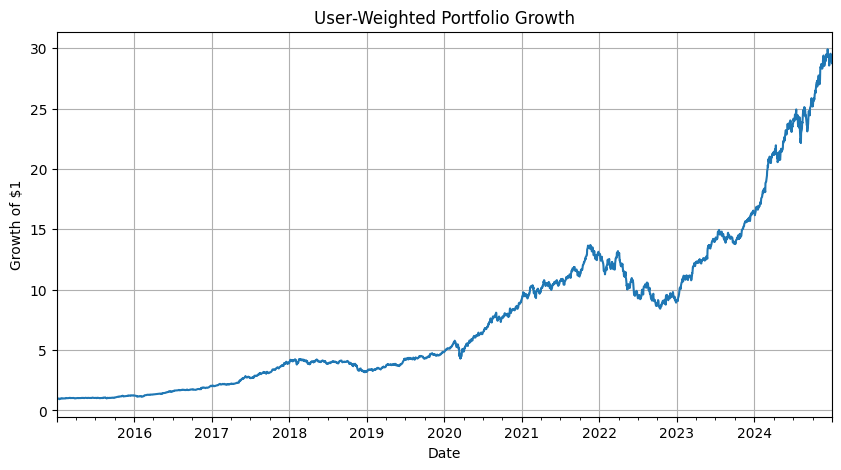

In [ ]:
plt.figure(figsize=(10,5))
cumulative_returns.plot(title="User‐Weighted Portfolio Growth")
plt.xlabel("Date"); plt.ylabel("Growth of $1"); plt.grid(True)
plt.show()

###Calculating all the different Performance Metrics Analysis

In [ ]:
def compute_performance_metrics(portfolio_returns,
                                risk_free_rate=0.03,
                                trading_days=252):
    """
    Given a pd.Series of daily portfolio returns, compute:
      - Cumulative Return
      - Annualized Return
      - Annualized Volatility
      - Sharpe Ratio
      - Maximum Drawdown
      - Maximum Drawdown Duration (in trading days)
    Returns a pd.Series of metrics.
    """
    # 1. Cumulative growth series of $1
    cumulative = (1 + portfolio_returns).cumprod()

    # 2. Cumulative Return
    cum_return = cumulative.iloc[-1] - 1

    # 3. Annualized Return & Volatility
    ann_return = portfolio_returns.mean() * trading_days
    ann_vol    = portfolio_returns.std() * np.sqrt(trading_days)

    # 4. Sharpe Ratio
    sharpe = (ann_return - risk_free_rate) / ann_vol

    # 5. Drawdowns
    running_max   = cumulative.cummax()
    drawdown      = cumulative / running_max - 1
    max_drawdown  = drawdown.min()

    # 6. Drawdown duration
    durations     = (drawdown < 0).astype(int)
    max_dur = 0
    curr_dur = 0
    for d in durations:
        if d:
            curr_dur += 1
            max_dur = max(max_dur, curr_dur)
        else:
            curr_dur = 0

    # Pack into Series
    metrics = pd.Series({
        'Cumulative Return':           cum_return,
        'Annualized Return':           ann_return,
        'Annualized Volatility':       ann_vol,
        'Sharpe Ratio':                sharpe,
        'Maximum Drawdown':            max_drawdown,
        'Max Drawdown Duration (days)': max_dur
    })

    return metrics

In [ ]:
metrics = compute_performance_metrics(portfolio_returns,
                                      risk_free_rate=0.03,
                                      trading_days=252)

print("\nPortfolio Performance Metrics:")
print(metrics.apply(lambda x: f"{x:.2%}" if isinstance(x, (float,np.floating)) else x))


Portfolio Performance Metrics:
Cumulative Return                2777.45%
Annualized Return                  24.42%
Annualized Volatility              15.65%
Sharpe Ratio                      136.82%
Maximum Drawdown                  -38.52%
Max Drawdown Duration (days)    56900.00%
dtype: object


###Correlation Analysis

In [ ]:
def correlation_analysis(asset_returns, window=60, base_asset=None):
    """
    Compute and (optionally) plot correlations.

    Parameters
    ----------
    asset_returns : pd.DataFrame
        Daily return series for each asset (columns are tickers).
    window : int
        Rolling window (in days) for rolling correlation.
    base_asset : str or None
        If provided, will plot each asset's rolling correlation vs this asset.

    Returns
    -------
    static_corr : pd.DataFrame
        Full-period Pearson correlation matrix.
    rolling_corr : pd.DataFrame
        Panel of rolling correlations: MultiIndex rows (date, asset_i),
        columns asset_j.
    rolling_vs_base : pd.Series or None
        If base_asset given, returns a DataFrame of rolling correlations
        vs base_asset (columns are other tickers). Otherwise, None.
    """
    # 1. Static correlation
    static_corr = asset_returns.corr()

    # 2. Rolling correlation panel
    rolling_corr = asset_returns.rolling(window).corr()

    rolling_vs_base = None
    if base_asset is not None:
        # Series of rolling corr between base_asset and each column
        rolling_vs_base = asset_returns[base_asset].rolling(window).corr(asset_returns)

        # Plot
        plt.figure(figsize=(12, 6))
        for ticker in asset_returns.columns:
            if ticker == base_asset:
                continue
            plt.plot(rolling_vs_base[ticker], label=f"{base_asset} ↔ {ticker}")
        plt.title(f"{window}-Day Rolling Correlation vs {base_asset}")
        plt.xlabel("Date")
        plt.ylabel("Correlation")
        plt.legend(loc="upper right", ncol=2)
        plt.grid(True)
        plt.show()

    return static_corr, rolling_corr, rolling_vs_base

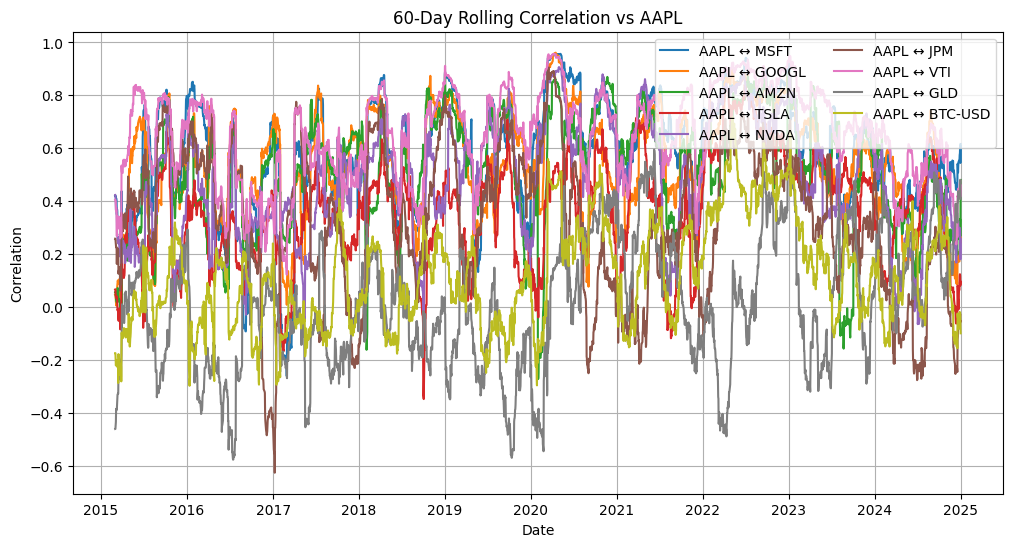

In [ ]:
static_corr, rolling_corr, rolling_vs_aapl = correlation_analysis(
    asset_returns,
    window=60,
    base_asset='AAPL'
)

##TO JUST GET ONE SINGLE CORRELATION?

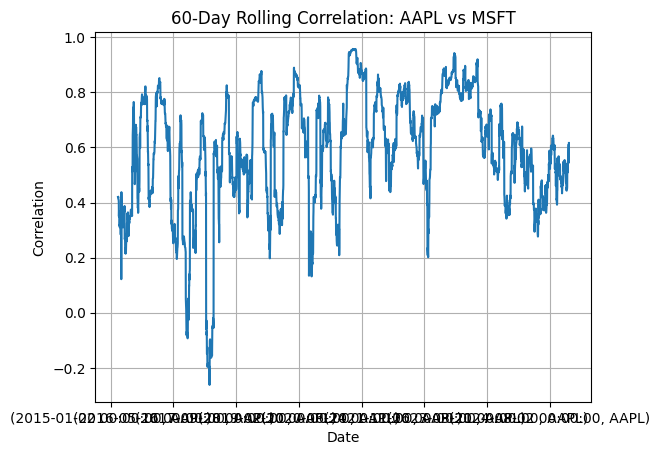

In [ ]:
# 60-day rolling corr of AAPL vs MSFT:
rolling_aapl_msft = rolling_corr.loc[(slice(None), 'AAPL'), 'MSFT']
rolling_aapl_msft.plot(title="60-Day Rolling Correlation: AAPL vs MSFT")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_performance_charts(asset_returns,
                            portfolio_returns,
                            rolling_window=60,
                            trading_days=252):
    """
    Plots:
      1. Portfolio cumulative return.
      2. Heatmap of asset correlation matrix.
      3. Rolling volatility of each asset + portfolio.
      4. Portfolio drawdown curve.

    Parameters
    ----------
    asset_returns : pd.DataFrame
        Daily return series for each asset (columns are tickers).
    portfolio_returns : pd.Series
        Daily return series of the portfolio.
    rolling_window : int
        Window (in days) for rolling stats.
    trading_days : int
        Number of trading days in a year for annualization.
    """
    # Pre-compute series
    cumulative = (1 + portfolio_returns).cumprod()
    corr_matrix = asset_returns.corr()
    rolling_vol_assets = asset_returns.rolling(rolling_window).std() * np.sqrt(trading_days)
    rolling_vol_port = portfolio_returns.rolling(rolling_window).std() * np.sqrt(trading_days)
    running_max = cumulative.cummax()
    drawdown = cumulative / running_max - 1

    # 1. Cumulative Return
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative.index, cumulative.values, label='Portfolio')
    plt.title("Portfolio Cumulative Return")
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Correlation Heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(corr_matrix.values, vmin=-1, vmax=1, interpolation='none')
    ax.set_xticks(np.arange(len(corr_matrix)))
    ax.set_yticks(np.arange(len(corr_matrix)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(corr_matrix.index)
    fig.colorbar(cax, ax=ax, label='Correlation')
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            text = f"{corr_matrix.values[i, j]:.2f}"
            color = "w" if abs(corr_matrix.values[i, j]) > 0.5 else "k"
            ax.text(j, i, text, ha="center", va="center", color=color)
    ax.set_title("Asset Return Correlation Heatmap")
    plt.tight_layout()
    plt.show()

    # 3. Rolling Volatility
    plt.figure(figsize=(12, 6))
    for ticker in rolling_vol_assets.columns:
        plt.plot(rolling_vol_assets.index,
                 rolling_vol_assets[ticker],
                 alpha=0.6,
                 label=ticker)
    plt.plot(rolling_vol_port.index,
             rolling_vol_port,
             color='k',
             lw=2,
             linestyle='--',
             label='Portfolio')
    plt.title(f"{rolling_window}-Day Rolling Volatility")
    plt.xlabel("Date")
    plt.ylabel("Annualized Volatility")
    plt.legend(ncol=2, fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 4. Drawdown Curve
    plt.figure(figsize=(10, 5))
    plt.plot(drawdown.index, drawdown.values, color='crimson', label='Drawdown')
    plt.fill_between(drawdown.index, drawdown.values, 0, color='crimson', alpha=0.3)
    plt.title("Portfolio Drawdown Curve")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()





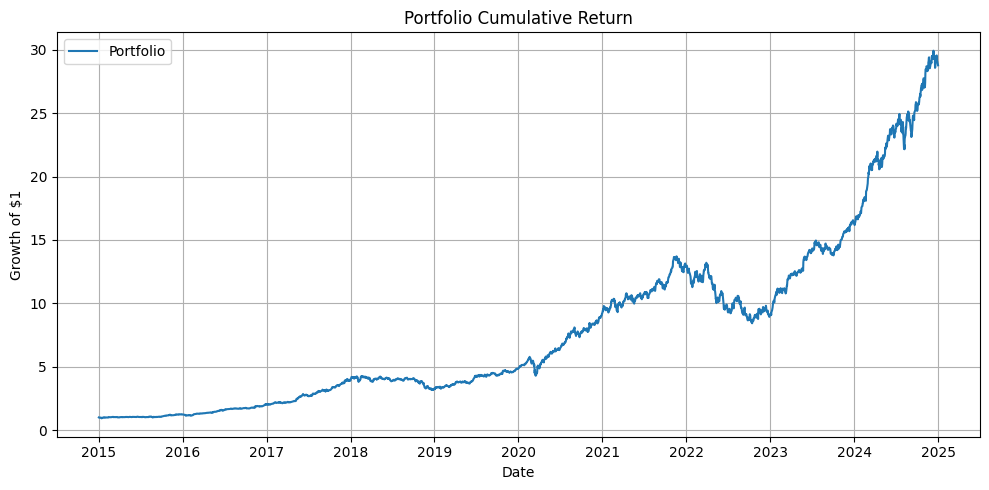

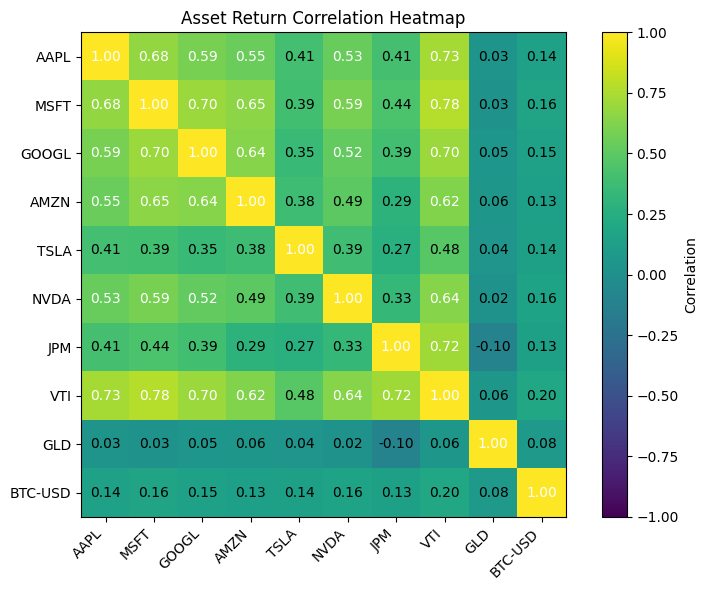

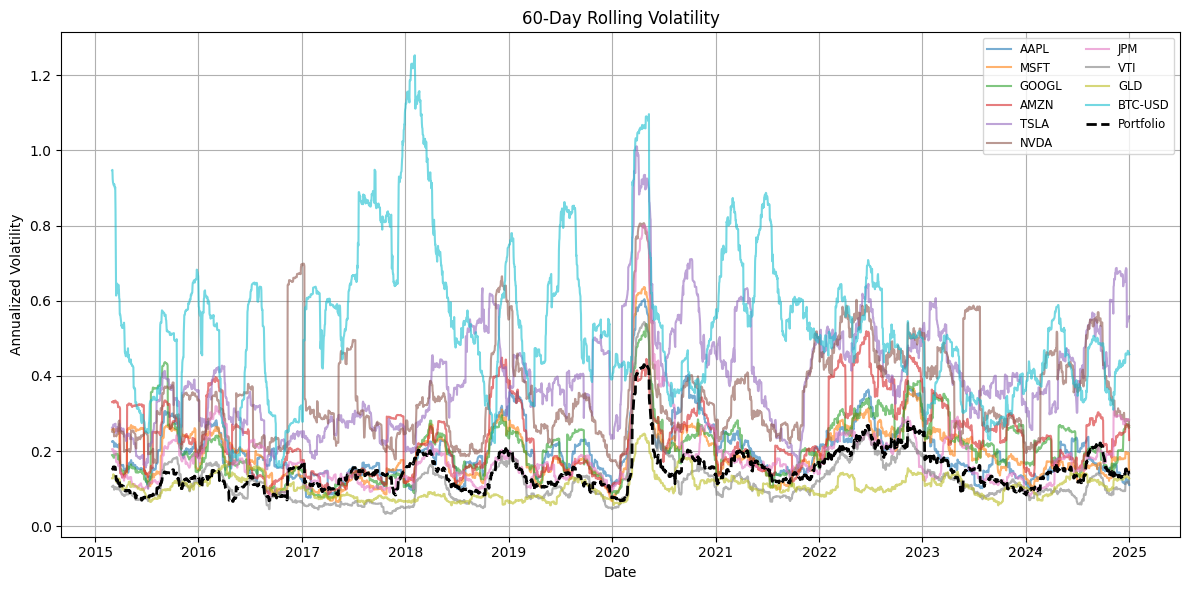

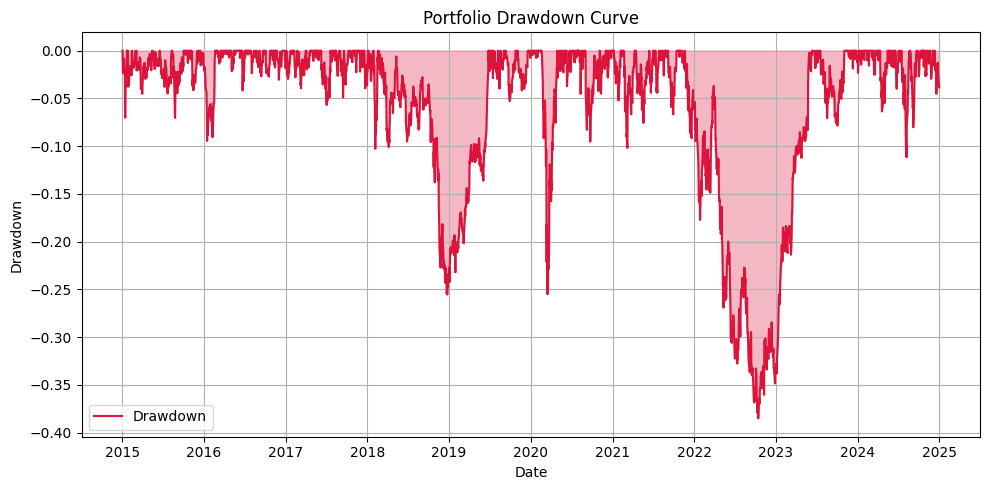

In [ ]:
# === Example call ===
# Assuming you already have:
#   asset_returns: pd.DataFrame of daily returns per asset
#   portfolio_returns: pd.Series of daily portfolio returns
plot_performance_charts(asset_returns, portfolio_returns, rolling_window=60, trading_days=252)

##COMPARISON FINAL!

In [ ]:


print("\nOptimized Weights (Max Sharpe):")
print(opt_weights)

opt_ret, opt_vol, opt_sh = portfolio_performance(opt_weights.values, asset_returns)
print(f"\nAnnualized Return: {opt_ret:.2%}")
print(f"Annualized Volatility: {opt_vol:.2%}")
print(f"Sharpe Ratio: {opt_sh:.2f}")

NameError: name 'optimize_sharpe' is not defined

In [ ]:
def run_full_analysis(weights, label, asset_returns, adj_close_prices):
    """
    Run full performance and risk analysis for a given portfolio weight configuration.

    Arguments:
    - weights: pd.Series of weights (index must match asset_returns columns)
    - label: str, label for printing/chart titles
    - asset_returns: DataFrame of daily asset returns
    - adj_close_prices: DataFrame of adjusted close prices
    """
    print(f"\n{'='*60}")
    print(f"🔍 Full Analysis for: {label}")
    print(f"{'='*60}")

    # 1. Daily portfolio returns
    portfolio_returns = asset_returns.dot(weights)

    # 2. Performance metrics
    perf_metrics = compute_performance_metrics(portfolio_returns)
    print("\n📊 Performance Metrics:")
    display(perf_metrics)

    # 3. Correlation + rolling correlation
    print("\n🔗 Correlation Analysis:")
    correlation_analysis(asset_returns)

    # 4. Plot all performance visualizations
    print("\n📈 Generating Plots...")
    plot_performance_charts(portfolio_returns, asset_returns, adj_close_prices, title_suffix=f"({label})")


In [ ]:
run_full_analysis(user_weights,    "User Portfolio",        asset_returns, adj_close)
run_full_analysis(sharpe_weights,  "Sharpe-Optimal",        asset_returns, adj_close)
run_full_analysis(minvol_weights,  "Minimum-Volatility",    asset_returns, adj_close)